#**Generative Adversarial Networks (Gans) for Tabular Synthetic Data**

#**All Imports**

In [1]:
import timeit
import platform
import numpy as np
import pandas as pd
%matplotlib inline
import os
import matplotlib.pyplot as plt
from numpy.random import randn
from matplotlib import pyplot

#**All Tensorflow 2.x imports**

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from keras.layers import Reshape
# from keras.layers import Flatten
# from keras.layers import Conv2D
# from keras.layers import Conv2DTranspose
# from keras.layers import LeakyReLU
# from keras.layers import BatchNormalization
# from keras.initializers import RandomNormal
# from matplotlib import pyplot

#**All Functions Definition**

In [3]:
def explore_data(data): 
  print("\nHead of Data: \n", data.head())
  print("\nTail of Data: \n", data.tail())
  print("\nShape of Data: ", data.shape)
  print("\nInformation about Data: \n")
  try: 
    data.info()
  except: 
    pass
  print("\nTypes of Data attributes: \n")
  try: 
    data.dtypes
  except: 
    pass
  print("\nSummary of all numerical fields in the dataset: \n")
  try: 
    data.describe(include = [np.number])
  except: 
    pass
  print("\nSummary of all categorical fields in the dataset: \n")
  try: 
    data.describe(include = ['O'])
  except: 
    pass
  print("\nLoop Through Each Column and Check for nulls: \n")
  try: 
    for i in range(len(data.columns)):
        print(data.columns[i] + ": " + str(data[data.columns[i]].isna().sum()))
  except: 
    pass
    
def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else: 
    return None    

# **Data Download - Diabetes, Telephony, etc.**

In [4]:
start_time = timeit.default_timer()
# Operating System
OS = platform.system()                           # returns 'Windows', 'Linux', etc

os.system('pip install --upgrade --no-cache-dir gdown')

out = data_download("./diabetes.zip", "1y-JNu2gHldlhhLfBD17mVj4wP69jx2ks", OS)
print("Elapsed Time: ", timeit.default_timer() - start_time)

Elapsed Time:  4.434121342999987


In [5]:
data = pd.read_csv('./diabetes.csv')
# data = pd.read_csv('/Iris.csv')

In [6]:
explore_data(data)


Head of Data: 
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Tail of Data: 
      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72       

In [7]:
data.Outcome.unique()

array([1, 0])

In [8]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

label = ['Outcome']
X = data[features]
y = data[label]

In [9]:
print (y)

     Outcome
0          1
1          0
2          1
3          0
4          1
..       ...
763        0
764        0
765        0
766        1
767        0

[768 rows x 1 columns]


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X_true_train, X_true_test, y_true_train, y_true_test = train_test_split(X, y, test_size=0.30, random_state=42)
clf_true = RandomForestClassifier(n_estimators=100)
clf_true.fit(X_true_train,y_true_train)

y_true_pred=clf_true.predict(X_true_test)
print("Base Accuracy:",metrics.accuracy_score(y_true_test, y_true_pred))
print("Base classification report:",metrics.classification_report(y_true_test, y_true_pred))

Base Accuracy: 0.7445887445887446
Base classification report:               precision    recall  f1-score   support

           0       0.80      0.81      0.81       151
           1       0.63      0.62      0.63        80

    accuracy                           0.74       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.74      0.74      0.74       231



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


In [11]:
X.shape

(768, 8)

In [12]:
data.shape

(768, 9)

In [13]:
print (y_true_test)

     Outcome
668        0
324        0
624        0
690        0
473        0
..       ...
619        1
198        1
538        0
329        0
302        0

[231 rows x 1 columns]


In [14]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [15]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = np.zeros((n_samples, 1))
	return X, y

In [16]:
# generate n real samples with class labels
def generate_real_samples(n):
  X = data.sample(n)

  #generate class labels
  y = np.ones((n, 1))
  return X, y

In [18]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=9):
  model = Sequential()
  model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
  model.add(Dense(30, activation='relu'))
  # model.add(Dense(n_outputs, activation='sigmoid'))
  model.add(Dense(n_outputs, activation='linear'))
  return model

In [19]:
generator1 = define_generator(10, 9)
generator1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                165       
                                                                 
 dense_1 (Dense)             (None, 30)                480       
                                                                 
 dense_2 (Dense)             (None, 9)                 279       
                                                                 
Total params: 924
Trainable params: 924
Non-trainable params: 0
_________________________________________________________________


In [20]:
# define the standalone discriminator model
def define_discriminator(n_inputs=9):
  model = Sequential()
  # model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer='he_uniform', input_shape=n_inputs))
  # model.add(BatchNormalization())
  # model.add(LeakyReLU(alpha=0.2))
  # model.add(Dense(25, activation='relu'))
  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
	# compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [21]:
discriminator1 = define_discriminator(9)
discriminator1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                250       
                                                                 
 dense_4 (Dense)             (None, 50)                1300      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


In [22]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

In [23]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
	# plot loss
	plt.subplot(1, 1, 1)
	plt.plot(d_hist, label='d')
	plt.plot(g_hist, label='gen')
	# plt.legend()
	# plot discriminator accuracy
	# pyplot.subplot(2, 1, 2)
	# pyplot.plot(a1_hist, label='acc-real')
	# pyplot.plot(a2_hist, label='acc-fake')
	plt.show()
	# save plot to file
	# plt.savefig('results_baseline/plot_line_plot_loss.png')
	plt.close()

In [24]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128):
  
  # determine half the size of one batch, for updating the discriminator
  half_batch = int(n_batch / 2)

  d_history = []
  g_history = []
  
  # manually enumerate epochs
  for epoch in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator
    d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
    d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    
    # create inverted labels for the fake samples
    y_gan = np.ones((n_batch, 1))
    
    # update the generator via the discriminator's error
    g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)

    print('>%d, d1=%.3f, d2=%.3f d=%.3f g=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
    d_history.append(d_loss)
    g_history.append(g_loss_fake)

  plot_history(d_history, g_history)

    # if i==999:
    #   np.savetxt("new_X.csv", X, delimiter=",")
    
    # evaluate the model every n_eval epochs
    # if (i+1) % n_eval == 0:
    #   summarize_performance(i, g_model, d_model, latent_dim)
  g_model.save('trained_generated_model_20210205_v3.h5')

In [25]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
  # scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], color='red')
	pyplot.scatter(x_fake[:, 0], color='blue')
	pyplot.show()

Output streaming troncato alle ultime 5000 righe.
>5001, d1=0.592, d2=0.506 d=0.549 g=1.320
>5002, d1=0.574, d2=0.476 d=0.525 g=1.313
>5003, d1=0.772, d2=0.736 d=0.754 g=1.299
>5004, d1=0.737, d2=0.618 d=0.678 g=1.324
>5005, d1=0.608, d2=0.687 d=0.647 g=1.296
>5006, d1=0.649, d2=0.503 d=0.576 g=1.388
>5007, d1=0.719, d2=0.534 d=0.626 g=1.227
>5008, d1=0.609, d2=0.739 d=0.674 g=1.242
>5009, d1=0.733, d2=0.768 d=0.751 g=1.344
>5010, d1=0.958, d2=0.642 d=0.800 g=1.209
>5011, d1=0.750, d2=0.739 d=0.744 g=1.148
>5012, d1=1.000, d2=0.667 d=0.833 g=1.005
>5013, d1=0.511, d2=0.782 d=0.647 g=1.025
>5014, d1=0.846, d2=0.718 d=0.782 g=1.109
>5015, d1=0.828, d2=0.666 d=0.747 g=1.194
>5016, d1=1.192, d2=0.944 d=1.068 g=1.025
>5017, d1=0.775, d2=1.038 d=0.907 g=1.132
>5018, d1=0.817, d2=0.667 d=0.742 g=1.320
>5019, d1=1.132, d2=0.577 d=0.855 g=1.284
>5020, d1=1.184, d2=0.875 d=1.029 g=0.943
>5021, d1=0.875, d2=1.086 d=0.980 g=1.025
>5022, d1=0.837, d2=0.609 d=0.723 g=1.025
>5023, d1=0.804, d2=1.087 

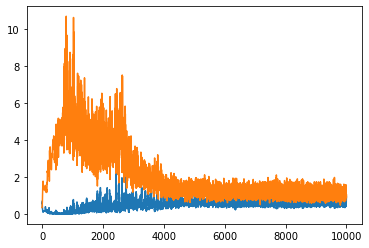

In [26]:
# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

In [27]:
from keras.models import load_model
model = load_model('./trained_generated_model_20210205_v3.h5')

In [28]:
t_points = generate_latent_points(10, 750)

In [29]:
X = model.predict(latent_points)

In [30]:
data_fake = pd.DataFrame(data=X,  columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'])

In [31]:
data_fake.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.588916,141.161819,85.953651,29.172098,125.001068,36.403267,1.090836,40.467472,0.278606
1,-1.404344,132.105362,89.876724,22.020287,7.323427,35.714603,1.030137,23.851349,-0.551047
2,6.599317,179.256256,111.860634,5.270302,-1.191388,30.292933,1.611171,76.947922,1.270966
3,-2.251765,183.266861,131.337982,39.972183,127.393394,46.074734,1.242136,56.102230,0.731984
4,14.986178,206.883240,106.025757,19.237413,1.668452,46.537601,2.675136,75.981773,-0.860706


In [32]:
data_fake.Outcome.min()

-3.4352688789367676

In [33]:
data_fake.Outcome.max()

3.820171594619751

In [34]:
outcome_mean = data_fake.Outcome.mean()

In [35]:
a_fake['Outcome'] = data_fake['Outcome'] > outcome_mean

In [36]:
data_fake['Outcome']

0       True
1      False
2       True
3       True
4      False
       ...  
745    False
746    False
747    False
748    False
749    False
Name: Outcome, Length: 750, dtype: bool

In [37]:
data_fake["Outcome"] = data_fake["Outcome"].astype(int)

In [38]:
data_fake.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.588916,141.161819,85.953651,29.172098,125.001068,36.403267,1.090836,40.467472,1
1,-1.404344,132.105362,89.876724,22.020287,7.323427,35.714603,1.030137,23.851349,0
2,6.599317,179.256256,111.860634,5.270302,-1.191388,30.292933,1.611171,76.947922,1
3,-2.251765,183.266861,131.337982,39.972183,127.393394,46.074734,1.242136,56.102230,1
4,14.986178,206.883240,106.025757,19.237413,1.668452,46.537601,2.675136,75.981773,0


In [39]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

label = ['Outcome']
X_fake_created = data_fake[features]
y_fake_created = data_fake[label]

In [40]:
X_fake_train, X_fake_test, y_fake_train, y_fake_test = train_test_split(X_fake_created, y_fake_created, test_size=0.30, random_state=42)
clf_fake = RandomForestClassifier(n_estimators=100)
clf_fake.fit(X_fake_train,y_fake_train)

y_fake_pred=clf_fake.predict(X_fake_test)
print("Accuracy of fake data model:",metrics.accuracy_score(y_fake_test, y_fake_pred))
print("Classification report of fake data model:",metrics.classification_report(y_fake_test, y_fake_pred))

Accuracy of fake data model: 0.8533333333333334
Classification report of fake data model:               precision    recall  f1-score   support

           0       0.89      0.83      0.86       123
           1       0.81      0.88      0.85       102

    accuracy                           0.85       225
   macro avg       0.85      0.86      0.85       225
weighted avg       0.86      0.85      0.85       225



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
X_final = X[:, :8]
print ('X_final: ', X_final[:3])

y_final = X[:, :]
print ('y_final: ', y_final[:3])

X_final:  [[ -0.58891565 141.16182     85.95365     29.172098   125.00107
   36.403267     1.0908358   40.467472  ]
 [ -1.4043436  132.10536     89.876724    22.020287     7.323427
   35.714603     1.0301368   23.851349  ]
 [  6.5993166  179.25626    111.860634     5.2703023   -1.1913877
   30.292933     1.6111711   76.94792   ]]
y_final:  [[ -0.58891565 141.16182     85.95365     29.172098   125.00107
   36.403267     1.0908358   40.467472     0.27860638]
 [ -1.4043436  132.10536     89.876724    22.020287     7.323427
   35.714603     1.0301368   23.851349    -0.55104697]
 [  6.5993166  179.25626    111.860634     5.2703023   -1.1913877
   30.292933     1.6111711   76.94792      1.270966  ]]


In [42]:
X = X [:,:8]

In [43]:
y_fake_pred = clf_true.predict(X)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [44]:
y_fake_pred

array([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,

In [45]:
!pip install table_evaluator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 285 kB 40.0 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [46]:
data_fake.shape

(750, 9)

In [47]:
data.shape

(768, 9)

In [48]:
data_fake.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.588916,141.161819,85.953651,29.172098,125.001068,36.403267,1.090836,40.467472,1
1,-1.404344,132.105362,89.876724,22.020287,7.323427,35.714603,1.030137,23.851349,0
2,6.599317,179.256256,111.860634,5.270302,-1.191388,30.292933,1.611171,76.947922,1
3,-2.251765,183.266861,131.337982,39.972183,127.393394,46.074734,1.242136,56.102230,1
4,14.986178,206.883240,106.025757,19.237413,1.668452,46.537601,2.675136,75.981773,0


In [50]:
from table_evaluator import TableEvaluator

In [51]:
table_evaluator = TableEvaluator(data, data_fake)

In [52]:
table_evaluator.evaluate(target_col='Outcome')


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.5533   0.8667              0.4085
DecisionTreeClassifier_real   0.7333   0.4600              0.3333
LogisticRegression_fake       0.4400   0.9400              0.2987
LogisticRegression_real       0.8267   0.3333              0.1811
MLPClassifier_fake            0.4667   0.9400              0.2987
MLPClassifier_real            0.7600   0.6000              0.3393
RandomForestClassifier_fake   0.4467   0.9400              0.3043
RandomForestClassifier_real   0.7800   0.3467              0.1952

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    1.5776
nearest neighbor std                     0.7603

Miscellaneous results:
                                  Result
Column Cor

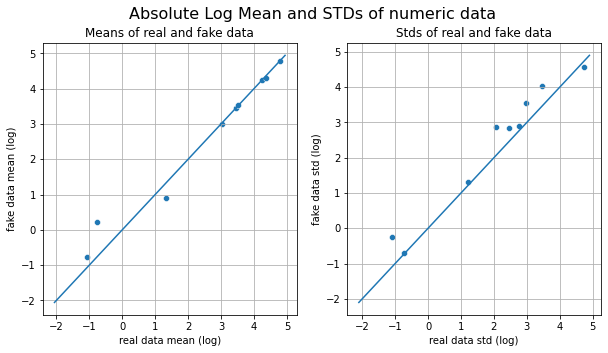

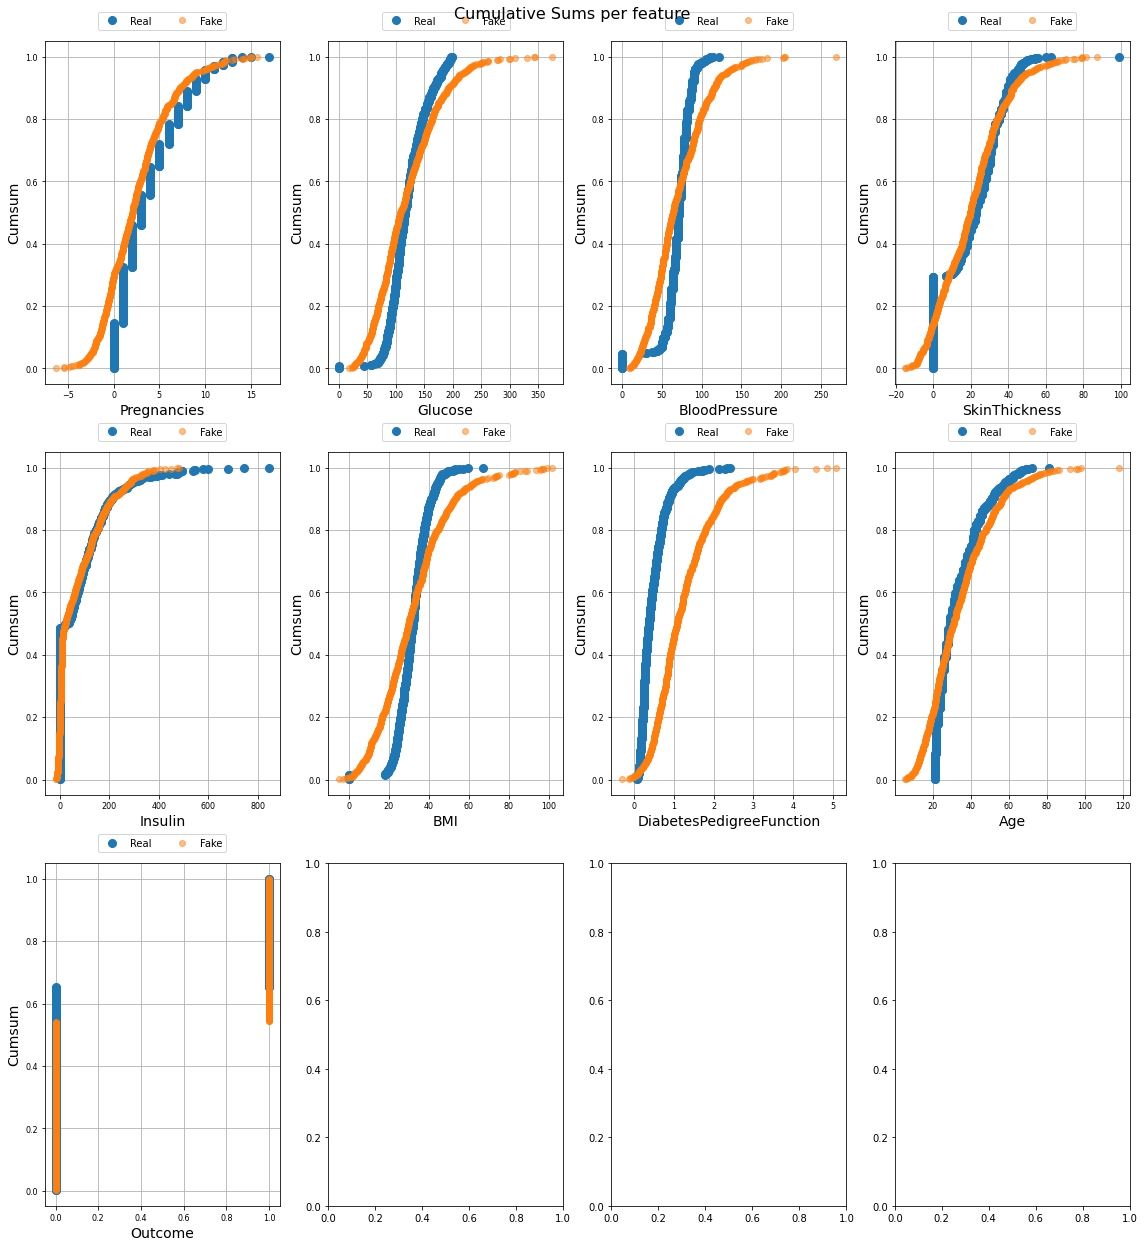

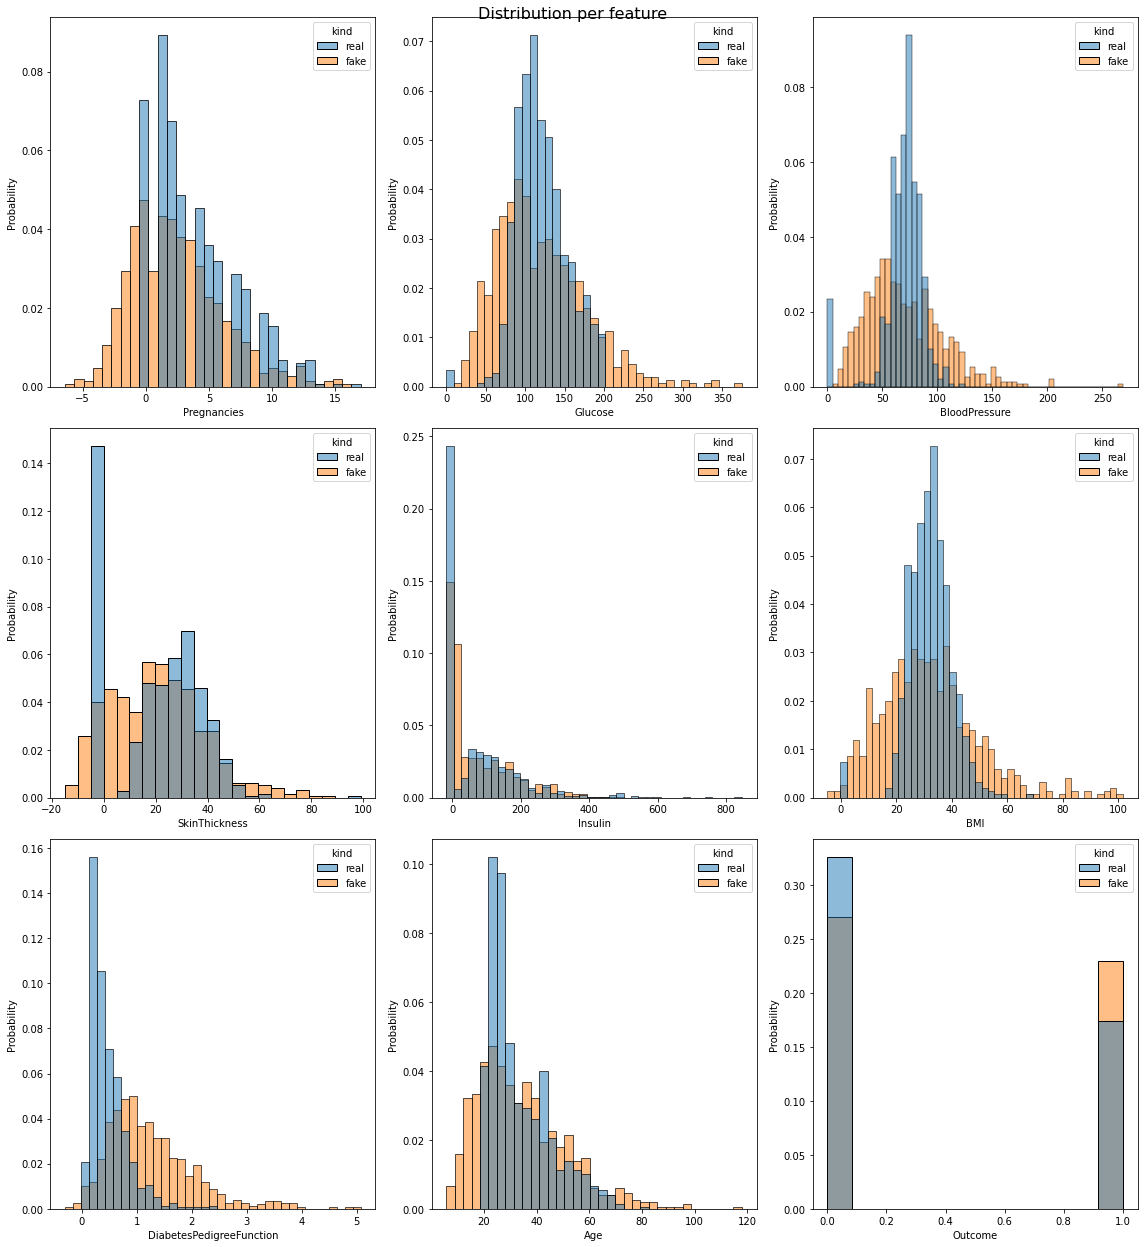

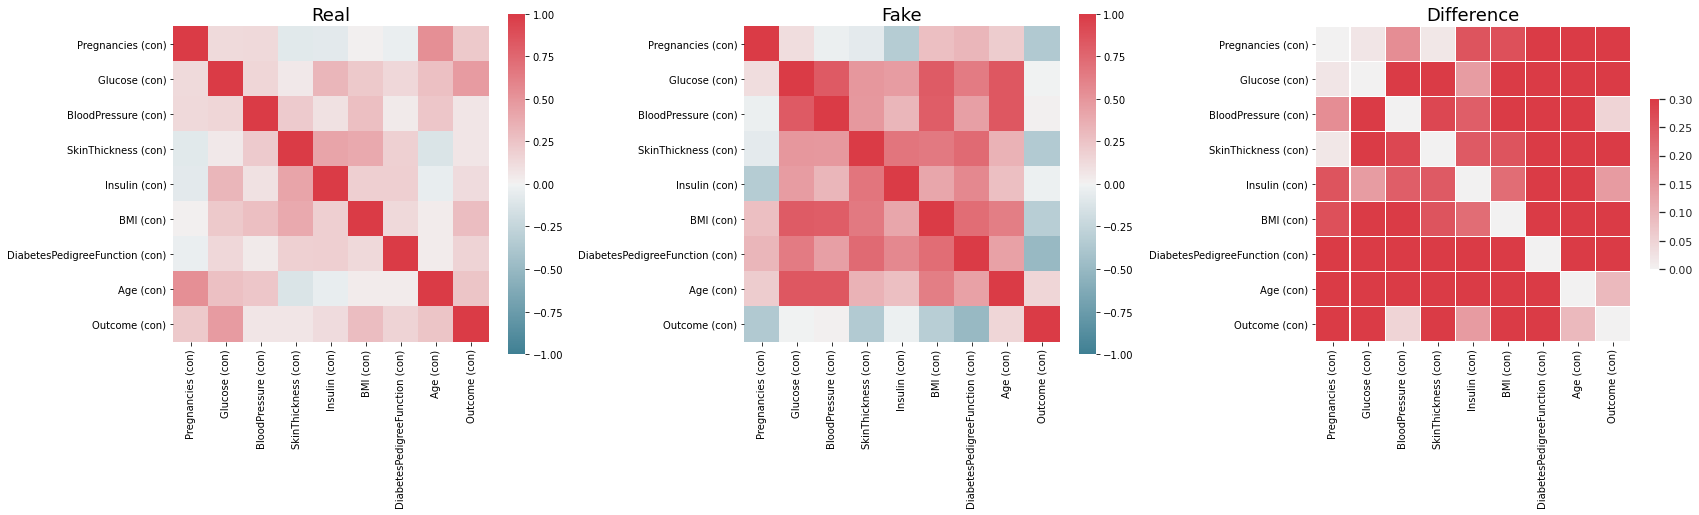

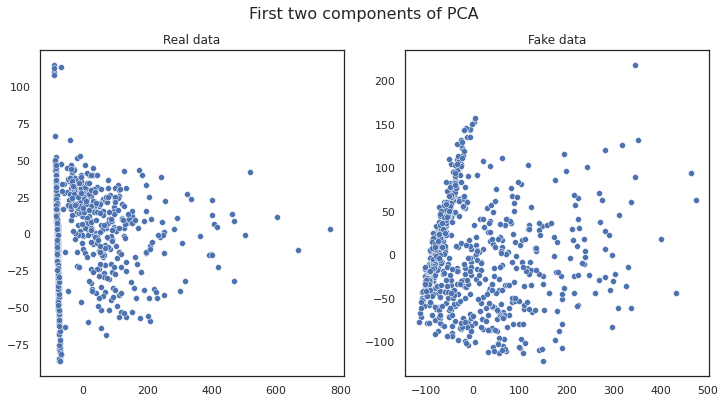

In [53]:
table_evaluator.visual_evaluation()